# Assignment 3

## 1 - Data Splitting

In [39]:
import os, os.path, shutil

In [40]:
# Extract Images
folder_path = r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct'''
# get all images that exist in the path listed above
images = [f for f in os.listdir(folder_path) 
          if os.path.isfile(os.path.join(folder_path, f))]
# Number of images in the folder above
print("Number of images: ", len(images))

Number of images:  1269


In [7]:
# Make training, validation, and test folders
train_path = os.path.join(folder_path, "train")
if not os.path.exists(train_path):
    os.makedirs(train_path)
    
validation_path = os.path.join(folder_path, "valid")
if not os.path.exists(validation_path):
    os.makedirs(validation_path)
    
test_path = os.path.join(folder_path, "test")
if not os.path.exists(test_path):
    os.makedirs(test_path)

In [ ]:
# Seperating images into different folders
# File Name Format = Sample_No_Alphabet_fileno.jpg
for image in images:
    # get the sample number
    sample_num = int(image.split('_')[1])
    # get the letter associated with the image
    letter = image.split('_')[2]
    
    # Destination of new file
    new_path = ""
    
    # Sample number 1 - 28 = Training set
    # Sample number 29 - 37 = Validation set
    # Sample number 38 - 47 = Test set
    if sample_num <= 29:
        new_path = os.path.join(train_path, letter)
    elif sample_num > 29 and sample_num <= 38:
        new_path = os.path.join(validation_path, letter)
    elif sample_num > 38 and sample_num <= 47:
        new_path = os.path.join(test_path, letter)
        
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    
    # Copy over new image
    old_path = os.path.join(folder_path, image)
    new_img_loc = os.path.join(new_path, image)
    shutil.copy(old_path, new_img_loc)

The data was split using an approximately 60:20:20 split. The respective number of images in each folder is listed below: 
 
 - Training : 783 images
 - Validation : 243 images
 - Test : 243 images
 - Total Images: 1,269

I was able to obtain this split by using sample numbers 1-29 for training, 30 - 38 for validation, and 39 - 47 for testing. I chose to seperate the samples into different sections to ensure a clear distinction between the different data sets. This is to ensure that the model isn't simply memorizing the training data, but rather learning from it. With the clear distinction between the sets, differentiating this should be fairly easy when testing, as we will be able to spot indications of overfitting. Furthermore, between all data sets, we ensured the distribution of all letters was uniform. For example, there is a 1/9 distribution between all letters, as well as letters between data sets. 

The 60:20:20 data set split was designed to ensure that training was occuring on the widest data set possible, along with the fact that the validation, and test data sets had enough images to ensure we were genuinly learning from the training data. 

## 2 - Convolutional Network 

### Initial Architecture Choice

General Layout: 
 - 2 convolution layers each followed up an activation function and maxpooling
 - 2 fully connected layers
 
Progression of image through the convolution network: 
 - Input Image: 3 * 224 * 224
 - After Conv1: 6 * 224 * 224
 - After MaxPool: 6 * 112 * 112
 - After Conv2: 12 * 112 * 112
 - After MaxPool: 12 * 56 * 56
 - After Fully Connected 1: 1 * 32
 - After Fully Connected 2: 1 * 9 -> Each output representing one of the 9 handsigns 
 
Note: The handSignClassifier was used for the training data collected in part 3. The handSignClassifierSmall and handSignClassifierLarge were created in part 4 for our hyperparam search. 

I decided to use both fully connected and convolutional layers within my network. Through the convolutional layers, we conducted feature extraction with filters of size 5 by 5. The pixels have spaitial importance, so by running this filter over the image we can extract useful characteristics. At each convolution layer, we doubled the output dimension (depth), while keeping the image size constant through the convolution . Along with this, by applying padding of size 2, I was able to preserve the important details found near the edges of the image. 

Each convolution layer was followed by max pooling and a ReLU function. Through max pooling, we aimied to both reduce the computational power required to process the image in further layers while also supressing the noise in adjacent pixels. ReLU functions have been documented to work extrememly well in modern architectures, while keeping the computational time to a minimum. 

We had two convolution layers so as not to loose too much information right away during feature extraction and down sampling our image. The pattern of halfing our image size, while doubling the output dimension in the convolution layer (depth) allowed us to achieve a fair balance for seperating features without using too much computation time. 

The problem with using fully connected layer right away is the immense amount of neurons and connections they will posses for a 224 * 224 image. By first applying the convolution layer, we were able to extract the main feature and store them in the least amount of space possible without loosing any important features. After achieving a better image size, we passed this image (12 * 56 * 56) to the fully connected layer. Furthermore, applying a fully connected layer right away requires flatening an image, causing pixels to loose all their spatial importance. By first extracting key features, then flatening the corresponding tensor, we can run that through the fully connected layers to obtain the appropriate predictions.

Similar to the reasoning described above for having 2 convolution layers, we also had 2 fully connected layers to limit the loss of information to the 9 output neurons. The second fully connected layer balances this to ensure we can achieve accurate predictions. 

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
class handSignClassifier(nn.Module):
    def __init__(self):
        super(handSignClassifier, self).__init__()
        self.name = "handSignClassifier"
        self.conv1 = nn.Conv2d(3, 6, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, padding = 2)
        self.fc1 = nn.Linear(12 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [43]:
class handSignClassifierSmall(nn.Module):
    def __init__(self):
        super(handSignClassifierSmall, self).__init__()
        self.name = "handSignClassifierSmall"
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 3, padding = 1)
        self.fc1 = nn.Linear(12 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
class handSignClassifierLarge(nn.Module):
    def __init__(self):
        super(handSignClassifierLarge, self).__init__()
        self.name = "handSignClassifierLarge"
        self.conv1 = nn.Conv2d(3, 6, 7, padding = 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 7, padding = 3)
        self.fc1 = nn.Linear(12 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 3 - Training Overfit

In [45]:
from torchvision import datasets, transforms

transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [46]:
# Testing a small data set to overfit

model = handSignClassifier()
training_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Overfit_Data\train'''
test_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Overfit_Data\test'''
train_data = datasets.ImageFolder(training_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

In [47]:
def get_accuracy(model, data, batch_size):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=True):
        # We don't need to run F.softmax
        output = model(imgs) 
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [48]:
def get_model_name(name, identity, batch_size, learning_rate, epoch):
    
    path = "model_{0}_{1}_bs{2}_lr{3}_epoch{4}".format(name,
                                                       identity,
                                                       batch_size,
                                                       learning_rate,
                                                       epoch)
    return path

In [49]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, train_data, val_data, batch_size=32, 
          num_epochs=1, learning_rate = 0.001, momentum = 0.9, identity = ""):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        # compute *average* loss
        losses.append(float(loss)/batch_size)                         
        # compute training accuracy
        train_acc.append(get_accuracy(model, train_data, batch_size))
        # compute training accuracy
        val_acc.append(get_accuracy(model, val_data, batch_size))   
        
        # Checkpoint to a file
        model_path = get_model_name(model.name, identity, 
                                    batch_size, learning_rate, epoch) 
        torch.save(model.state_dict(), model_path)
    
        print("Epoch {0: d}: Train Loss: {1: .2f}, Train Accuracy: {2: .2f}, Validation Accuracy: {3: .2f}"
              .format(epoch, loss, train_acc[-1], val_acc[-1]))
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch  0: Train Loss:  1.15, Train Accuracy:  0.56, Validation Accuracy:  0.11
Epoch  1: Train Loss:  2.09, Train Accuracy:  0.44, Validation Accuracy:  0.11
Epoch  2: Train Loss:  1.48, Train Accuracy:  0.50, Validation Accuracy:  0.11
Epoch  3: Train Loss:  0.01, Train Accuracy:  0.48, Validation Accuracy:  0.11
Epoch  4: Train Loss:  0.60, Train Accuracy:  0.52, Validation Accuracy:  0.11
Epoch  5: Train Loss:  0.68, Train Accuracy:  0.61, Validation Accuracy:  0.11
Epoch  6: Train Loss:  3.21, Train Accuracy:  0.59, Validation Accuracy:  0.19
Epoch  7: Train Loss:  1.09, Train Accuracy:  0.65, Validation Accuracy:  0.19
Epoch  8: Train Loss:  1.67, Train Accuracy:  0.74, Validation Accuracy:  0.19
Epoch  9: Train Loss:  1.10, Train Accuracy:  0.74, Validation Accuracy:  0.15
Epoch  10: Train Loss:  0.91, Train Accuracy:  0.59, Validation Accuracy:  0.26
Epoch  11: Train Loss:  0.78, Train Accuracy:  0.78, Validation Accuracy:  0.19
Epoch  12: Train Loss:  0.00, Train Accuracy:  0.7

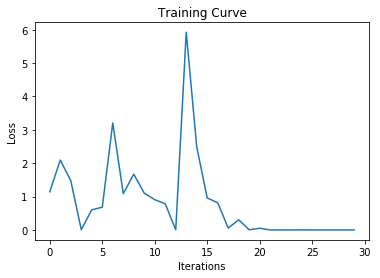

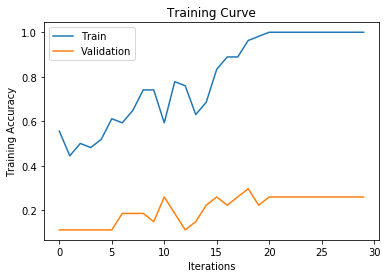

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.25925925925925924


In [183]:
train(model, train_data, test_data, 1, num_epochs=30, identity = "overfit")

### Overfitting ConvNet 

In the graph shown above, to ensure that my network is working correctly, I attempted to overfit my data set. I used the small sample provided to us earlier on to achieve a training accuracy of 100%. The validation accuracy hoeverd around the 25% mark indicating that the neural network was simply memorizing the training data. 

## 3 - Training Actual

In [199]:
from torchvision import datasets, transforms

model = handSignClassifier()
training_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\train'''
valid_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\valid'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(training_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)

Epoch  0: Train Loss:  2.17, Train Accuracy:  0.17, Validation Accuracy:  0.15
Epoch  1: Train Loss:  2.07, Train Accuracy:  0.23, Validation Accuracy:  0.24
Epoch  2: Train Loss:  1.71, Train Accuracy:  0.50, Validation Accuracy:  0.49
Epoch  3: Train Loss:  0.96, Train Accuracy:  0.66, Validation Accuracy:  0.58
Epoch  4: Train Loss:  1.24, Train Accuracy:  0.64, Validation Accuracy:  0.56
Epoch  5: Train Loss:  0.72, Train Accuracy:  0.77, Validation Accuracy:  0.63
Epoch  6: Train Loss:  0.51, Train Accuracy:  0.80, Validation Accuracy:  0.64
Epoch  7: Train Loss:  0.84, Train Accuracy:  0.72, Validation Accuracy:  0.61
Epoch  8: Train Loss:  0.66, Train Accuracy:  0.85, Validation Accuracy:  0.68
Epoch  9: Train Loss:  0.73, Train Accuracy:  0.84, Validation Accuracy:  0.65
Epoch  10: Train Loss:  0.15, Train Accuracy:  0.88, Validation Accuracy:  0.67
Epoch  11: Train Loss:  0.91, Train Accuracy:  0.80, Validation Accuracy:  0.65
Epoch  12: Train Loss:  0.68, Train Accuracy:  0.8

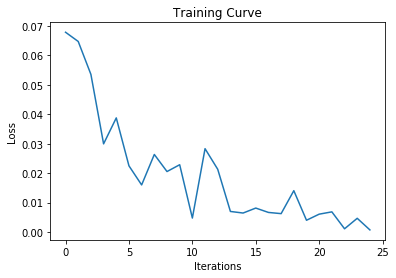

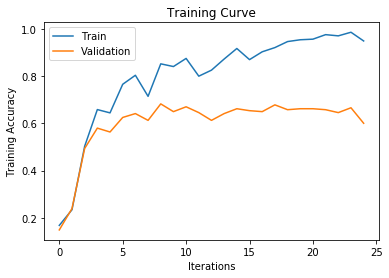

Final Training Accuracy: 0.9501915708812261
Final Validation Accuracy: 0.6008230452674898


In [193]:
train(model, train_data, valid_data, 
      batch_size = 32, num_epochs = 25, identity = "full")

## 4.a - Hyperparameter Search

I believe the following 3 hyperparameters will make the greatest difference to my neural network: 
- Kernel Size
- Momentum
- Learning Rate

In modern convolutional neural network architecture their has been a shift in kernel size from 5 * 5 to 3 * 3 and 1 * 1. The reason for this is that successive convolutions for smaller kernel sizes can represent a larger kernal size, while saving on computional power and increasing the field of depth. Small filters can aid in detecting local features at the cost of loosing the spaital importance of the pixel. I will explore how extracting lower features aids in the training/validation accuracy. 

Momentum is used to prevent the model from stagnating at a false local minima, or flatter regions in the gradient descent. By retaining more information on how the gradient descent was progressing, I will be exploring how this aids in the traiining/validation accuracy.   

Learning rate is another important hyperparameters. A larger learning rate can overshoot the global minima, while a smaller learning rate might take too long to reach one within a designated number of epochs. Finding the balance is important to ensure we reach the global minima and computationaly feasible amount of time 

## 4.b - Hyperparameter Testing

### Modified kernel size with constant layers and reduced kernel size of 3 * 3

In [200]:
model = handSignClassifierSmall()
training_path = r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\train'''
valid_path = r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\valid'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(training_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)

Epoch  0: Train Loss:  2.17, Train Accuracy:  0.13, Validation Accuracy:  0.11
Epoch  1: Train Loss:  2.16, Train Accuracy:  0.22, Validation Accuracy:  0.23
Epoch  2: Train Loss:  2.17, Train Accuracy:  0.23, Validation Accuracy:  0.22
Epoch  3: Train Loss:  2.10, Train Accuracy:  0.29, Validation Accuracy:  0.31
Epoch  4: Train Loss:  2.07, Train Accuracy:  0.27, Validation Accuracy:  0.24
Epoch  5: Train Loss:  1.71, Train Accuracy:  0.38, Validation Accuracy:  0.32
Epoch  6: Train Loss:  1.83, Train Accuracy:  0.50, Validation Accuracy:  0.41
Epoch  7: Train Loss:  0.95, Train Accuracy:  0.52, Validation Accuracy:  0.41
Epoch  8: Train Loss:  1.27, Train Accuracy:  0.57, Validation Accuracy:  0.46
Epoch  9: Train Loss:  1.23, Train Accuracy:  0.56, Validation Accuracy:  0.45
Epoch  10: Train Loss:  1.24, Train Accuracy:  0.58, Validation Accuracy:  0.47
Epoch  11: Train Loss:  0.97, Train Accuracy:  0.61, Validation Accuracy:  0.48
Epoch  12: Train Loss:  1.40, Train Accuracy:  0.5

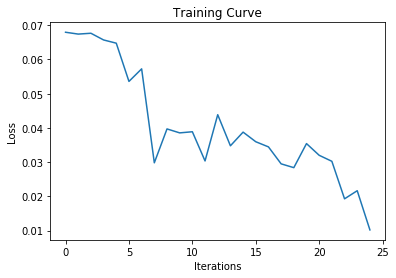

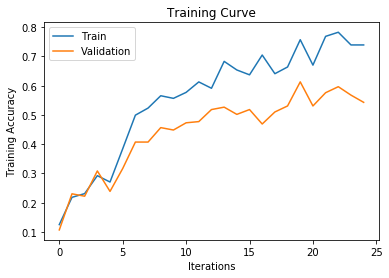

Final Training Accuracy: 0.7394636015325671
Final Validation Accuracy: 0.5432098765432098


In [201]:
train(model, train_data, valid_data, 
      batch_size = 32, num_epochs = 25, identity = "reducedKernel")

### Increasing Kernel size to 7 * 7

Epoch  0: Train Loss:  2.18, Train Accuracy:  0.14, Validation Accuracy:  0.13
Epoch  1: Train Loss:  2.19, Train Accuracy:  0.15, Validation Accuracy:  0.12
Epoch  2: Train Loss:  2.13, Train Accuracy:  0.31, Validation Accuracy:  0.21
Epoch  3: Train Loss:  1.73, Train Accuracy:  0.46, Validation Accuracy:  0.38
Epoch  4: Train Loss:  1.25, Train Accuracy:  0.56, Validation Accuracy:  0.53
Epoch  5: Train Loss:  0.94, Train Accuracy:  0.69, Validation Accuracy:  0.56
Epoch  6: Train Loss:  0.78, Train Accuracy:  0.67, Validation Accuracy:  0.56
Epoch  7: Train Loss:  0.66, Train Accuracy:  0.75, Validation Accuracy:  0.59
Epoch  8: Train Loss:  0.30, Train Accuracy:  0.82, Validation Accuracy:  0.67
Epoch  9: Train Loss:  0.56, Train Accuracy:  0.78, Validation Accuracy:  0.63
Epoch  10: Train Loss:  0.39, Train Accuracy:  0.83, Validation Accuracy:  0.62
Epoch  11: Train Loss:  0.14, Train Accuracy:  0.86, Validation Accuracy:  0.67
Epoch  12: Train Loss:  0.98, Train Accuracy:  0.8

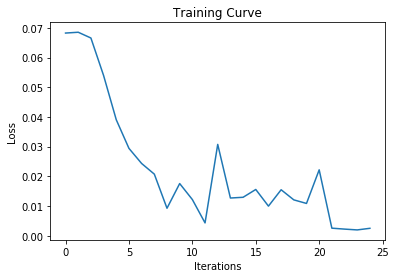

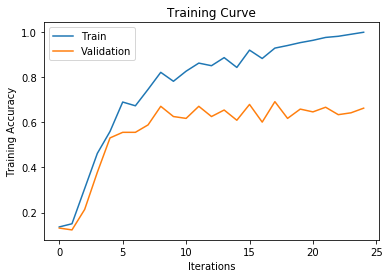

Final Training Accuracy: 0.9987228607918263
Final Validation Accuracy: 0.6625514403292181


In [213]:
model = handSignClassifierLarge()
train(model, train_data, valid_data, 
      batch_size = 32, num_epochs = 25, identity = "largeKernel")

### Increasing Momentum to 0.99 to Remember More History

In [203]:
model = handSignClassifier()

Epoch  0: Train Loss:  2.15, Train Accuracy:  0.17, Validation Accuracy:  0.14
Epoch  1: Train Loss:  2.13, Train Accuracy:  0.33, Validation Accuracy:  0.34
Epoch  2: Train Loss:  1.29, Train Accuracy:  0.54, Validation Accuracy:  0.47
Epoch  3: Train Loss:  0.94, Train Accuracy:  0.51, Validation Accuracy:  0.40
Epoch  4: Train Loss:  1.54, Train Accuracy:  0.54, Validation Accuracy:  0.47
Epoch  5: Train Loss:  1.13, Train Accuracy:  0.60, Validation Accuracy:  0.58
Epoch  6: Train Loss:  1.25, Train Accuracy:  0.72, Validation Accuracy:  0.59
Epoch  7: Train Loss:  0.45, Train Accuracy:  0.74, Validation Accuracy:  0.62
Epoch  8: Train Loss:  0.53, Train Accuracy:  0.78, Validation Accuracy:  0.62
Epoch  9: Train Loss:  0.26, Train Accuracy:  0.82, Validation Accuracy:  0.63
Epoch  10: Train Loss:  0.65, Train Accuracy:  0.80, Validation Accuracy:  0.65
Epoch  11: Train Loss:  0.70, Train Accuracy:  0.88, Validation Accuracy:  0.66
Epoch  12: Train Loss:  0.15, Train Accuracy:  0.9

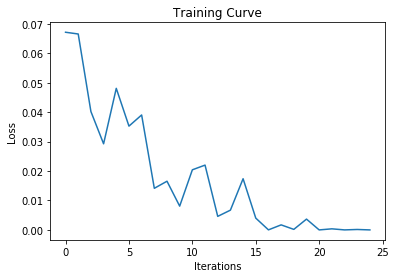

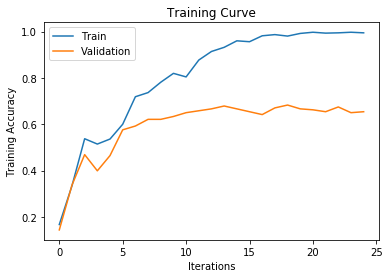

Final Training Accuracy: 0.9948914431673053
Final Validation Accuracy: 0.654320987654321


In [204]:
train(model, train_data, valid_data, 
      batch_size = 32, num_epochs = 25, momentum = 0.99, identity = "increasedMomentum")

### Decreasing Learning Rate to 0.0001

In [207]:
model = handSignClassifier()

Epoch  0: Train Loss:  2.23, Train Accuracy:  0.11, Validation Accuracy:  0.11
Epoch  1: Train Loss:  2.20, Train Accuracy:  0.11, Validation Accuracy:  0.11
Epoch  2: Train Loss:  2.24, Train Accuracy:  0.11, Validation Accuracy:  0.11
Epoch  3: Train Loss:  2.20, Train Accuracy:  0.12, Validation Accuracy:  0.12
Epoch  4: Train Loss:  2.22, Train Accuracy:  0.12, Validation Accuracy:  0.12
Epoch  5: Train Loss:  2.18, Train Accuracy:  0.15, Validation Accuracy:  0.14
Epoch  6: Train Loss:  2.18, Train Accuracy:  0.15, Validation Accuracy:  0.14
Epoch  7: Train Loss:  2.19, Train Accuracy:  0.16, Validation Accuracy:  0.14
Epoch  8: Train Loss:  2.20, Train Accuracy:  0.19, Validation Accuracy:  0.18
Epoch  9: Train Loss:  2.20, Train Accuracy:  0.21, Validation Accuracy:  0.19
Epoch  10: Train Loss:  2.19, Train Accuracy:  0.22, Validation Accuracy:  0.19
Epoch  11: Train Loss:  2.19, Train Accuracy:  0.24, Validation Accuracy:  0.21
Epoch  12: Train Loss:  2.16, Train Accuracy:  0.2

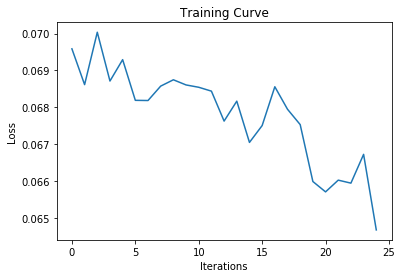

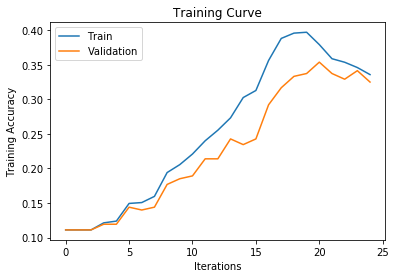

Final Training Accuracy: 0.33588761174968074
Final Validation Accuracy: 0.32510288065843623


In [208]:
train(model, train_data, valid_data, batch_size = 32, 
      num_epochs = 25, learning_rate = 0.0001, identity = "decreasedLR")

### Combined Parameters

In [214]:
model = handSignClassifierLarge()

Epoch  0: Train Loss:  2.21, Train Accuracy:  0.13, Validation Accuracy:  0.11
Epoch  1: Train Loss:  2.07, Train Accuracy:  0.14, Validation Accuracy:  0.13
Epoch  2: Train Loss:  2.19, Train Accuracy:  0.55, Validation Accuracy:  0.48
Epoch  3: Train Loss:  4.33, Train Accuracy:  0.59, Validation Accuracy:  0.50
Epoch  4: Train Loss:  1.70, Train Accuracy:  0.42, Validation Accuracy:  0.38
Epoch  5: Train Loss:  1.25, Train Accuracy:  0.54, Validation Accuracy:  0.51
Epoch  6: Train Loss:  1.05, Train Accuracy:  0.68, Validation Accuracy:  0.56
Epoch  7: Train Loss:  0.66, Train Accuracy:  0.73, Validation Accuracy:  0.65
Epoch  8: Train Loss:  1.18, Train Accuracy:  0.75, Validation Accuracy:  0.58
Epoch  9: Train Loss:  0.66, Train Accuracy:  0.82, Validation Accuracy:  0.62
Epoch  10: Train Loss:  0.70, Train Accuracy:  0.84, Validation Accuracy:  0.61
Epoch  11: Train Loss:  0.16, Train Accuracy:  0.91, Validation Accuracy:  0.67
Epoch  12: Train Loss:  0.05, Train Accuracy:  0.9

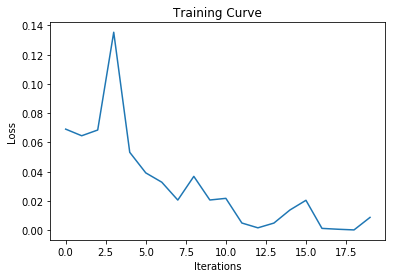

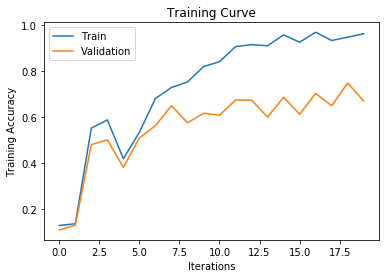

Final Training Accuracy: 0.9629629629629629
Final Validation Accuracy: 0.6707818930041153


In [215]:
train(model, train_data, valid_data, 
      batch_size = 32, num_epochs = 20, momentum = 0.99, identity = "Combined")

## 4.c - Model Selection

I chose the combined model described in section 4.b with the following parameters: 
 - Kernel Size: 7 * 7
 - Epoch = 19
 - Learning Rate = 0.001
 - Momentum = 0.99
 - Batch Size = 32
 - Layers = 2 Convolution followed by 2 Pool/Relu and 2 Fully Connected

I chose the following settings, since during they hyper parameter search the aformentioned attributes translated to the best validation accuracy. Inidicating that the training done on the training data set was effective on a "random" dataset. The kernel size of 7 * 7 performed much better than 5 * 5, a higher momentum also aided in increasing the validation accuracy. Finally, testing all of the aformentioned atributes together, i found that at epoch 18, we were able to achieve the highest training/validation accuracy before overfitting began to occur. For this reason, I chose this as the ideal model to predict handsigns between A - I.  

In [229]:
net = handSignClassifierLarge() 
model_path = 
get_model_name(net.name, "Combined", 
               batch_size=32, learning_rate=0.001, epoch=18)
state = torch.load(model_path)
net.load_state_dict(state)

## 4.d - Test accuracy

In [230]:
test_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\test'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_data = datasets.ImageFolder(test_path, transform=transform)

In [232]:
print("Final Valid Accuracy: {0}".format(get_accuracy(net, 
                                                      valid_data, batch_size=32)))
print("Final Test Accuracy: {0}".format(get_accuracy(net, 
                                                     test_data, batch_size=32)))

Final Valid Accuracy: 0.7489711934156379
Final Test Accuracy: 0.5308641975308642


## 5 - Transfer Learning

## 5.a - Load AlexNet

In [27]:
import numpy as np
from a3code import AlexNetFeatures
myfeature_model = AlexNetFeatures()

In [28]:
def feature_extractor(model, data, typeData):
    data_loader = torch.utils.data.DataLoader(data, batch_size=1)
    
    # Saving the models on disk to aid in training time
    n = 0
    for imgs, labels in iter(data_loader):
        extracted_features = model(imgs)
        torch.save(extracted_features, 
                   "alexnet_features_{0}_it{1}_name_{2}".format(labels[0], n, typeData))
        n += 1

In [29]:
from torchvision import datasets, transforms

model = handSignClassifier()
training_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\train'''
valid_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\valid'''
test_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\test'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(training_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

In [30]:
# Extracting all features to disk
feature_extractor(myfeature_model, train_data, "train")
feature_extractor(myfeature_model, valid_data, "valid")
feature_extractor(myfeature_model, test_data, "test")

I extracted the features of all the models above and saved them directly on disk using the following naming convention:
 - alexnet_features_{}_it_{}_name_{}

## 5.b - Convolutional Neural Network 

General Layout: 
 - 1 convolution layers each followed up an activation function and maxpooling
 - 1 fully connected layers
 
Progression of image through the convolution network: 
 - Input Image: 256 * 6 * 6
 - After Conv1: 256 * 4 * 4
 - After MaxPool: 256 * 2 * 2
 - After Fully Connected 1: 1 * 9 -> 1 neuron representing each handsign
 
Due to the large feature extraction that took place in alexnet, i simply had 1 convolutional layer with ReLU/MaxPooling followed by 1 fully connected layer. As we were fine tuning over an already deep network, creating a larger network over this was not my primary goal. Rather, I was hoping to fit this exisiting network to my needs of handsign detection. 

Due to the large depth (feature extraction) already present in the output, I only have 1 convolution layer that doubles the output dimension while keeping the size of the image constant. This is a common practise found in convolutional neural networks: IE -> doubling the output dimension. After this, I applied MaxPooling to condense information as well as remove excess noise and then a nonlinear ReLU activation function. 

After this, I flatten the resulting image and pass it into my fully connected layer downsizing from 512 * 3 * 3 to 9 output neurons. Once again, I believed only 1 layer was required for the fine tuning process as a lot of the heavy lifiting was done by AlexNet. 

In [79]:
class handSignTransferLearn(nn.Module):
    def __init__(self):
        super(handSignTransferLearn, self).__init__()
        self.name = "handSignTransferLearn"
        self.conv1 = nn.Conv2d(256, 512, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 3 * 3, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 512 * 3 * 3)
        x = F.relu(self.fc1(x))
        return x

## 5.c - Network Training

In [80]:
def get_accuracyTransferLearn(model, modelAlex, data, batch_size):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, 
                                                    batch_size=batch_size, shuffle=True):
        feature = modelAlex(imgs)
        output = model(feature) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [81]:
import math 

def trainTransferLearn(model, modelAlex, train_data, val_data, batch_size=32, num_epochs=1, 
                       learning_rate = 0.001, momentum = 0.9, identity = ""):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            feature = modelAlex(imgs)
            out = model(feature)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)                         # compute *average* loss
        train_acc.append(get_accuracyTransferLearn(model, modelAlex, train_data, batch_size)) # compute training accuracy
        val_acc.append(get_accuracyTransferLearn(model, modelAlex, val_data, batch_size))   # compute training accuracy
        
        # Checkpoint to a file
        model_path = get_model_name(model.name, identity, batch_size, learning_rate, epoch) 
        torch.save(model.state_dict(), model_path)
    
        print("Epoch {0: d}: Train Loss: {1: .2f}, Train Accuracy: {2: .2f}, Validation Accuracy: {3: .2f}".
              format(epoch, loss, train_acc[-1], val_acc[-1]))
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [82]:
model = handSignClassifierSmall()
training_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Overfit_Data\train'''
valid_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Overfit_Data\test'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(training_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)

### Overfitting to ensure model works

Epoch  0: Train Loss:  2.17, Train Accuracy:  0.28, Validation Accuracy:  0.22
Epoch  1: Train Loss:  2.14, Train Accuracy:  0.35, Validation Accuracy:  0.15
Epoch  2: Train Loss:  2.17, Train Accuracy:  0.43, Validation Accuracy:  0.22
Epoch  3: Train Loss:  1.97, Train Accuracy:  0.44, Validation Accuracy:  0.30
Epoch  4: Train Loss:  1.98, Train Accuracy:  0.46, Validation Accuracy:  0.33


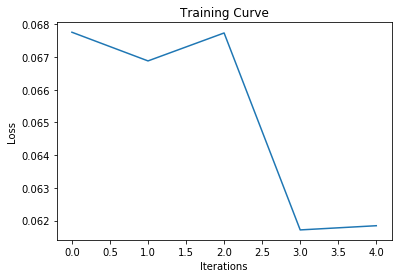

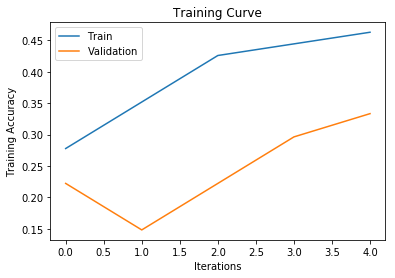

Final Training Accuracy: 0.46296296296296297
Final Validation Accuracy: 0.3333333333333333


In [83]:
model = handSignTransferLearn()
trainTransferLearn(model, myfeature_model, 
                   train_data, valid_data, num_epochs = 5, identity = "transferLearn")

In [84]:
training_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\train'''
valid_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\valid'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(training_path, transform=transform)
valid_data = datasets.ImageFolder(valid_path, transform=transform)

### Hyperparameter Tuning

Epoch  0: Train Loss:  1.58, Train Accuracy:  0.60, Validation Accuracy:  0.61
Epoch  1: Train Loss:  1.02, Train Accuracy:  0.71, Validation Accuracy:  0.72
Epoch  2: Train Loss:  0.68, Train Accuracy:  0.73, Validation Accuracy:  0.72
Epoch  3: Train Loss:  0.97, Train Accuracy:  0.73, Validation Accuracy:  0.74
Epoch  4: Train Loss:  0.36, Train Accuracy:  0.78, Validation Accuracy:  0.74
Epoch  5: Train Loss:  0.57, Train Accuracy:  0.77, Validation Accuracy:  0.77
Epoch  6: Train Loss:  0.84, Train Accuracy:  0.81, Validation Accuracy:  0.76
Epoch  7: Train Loss:  1.14, Train Accuracy:  0.82, Validation Accuracy:  0.76
Epoch  8: Train Loss:  0.49, Train Accuracy:  0.83, Validation Accuracy:  0.76
Epoch  9: Train Loss:  0.49, Train Accuracy:  0.81, Validation Accuracy:  0.77


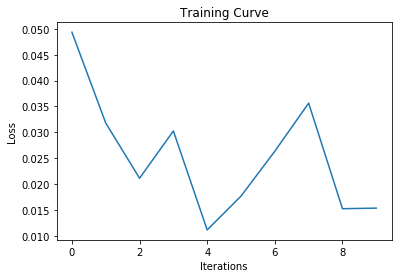

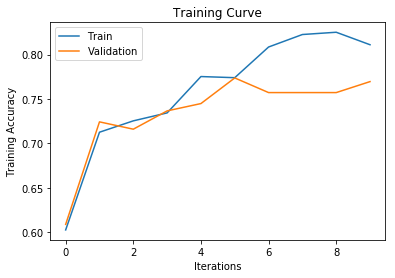

Final Training Accuracy: 0.8109833971902938
Final Validation Accuracy: 0.7695473251028807


In [86]:
model = handSignTransferLearn()
trainTransferLearn(model, myfeature_model, 
                   train_data, valid_data, num_epochs = 10, identity = "transferLearnActual")

The following hyperparameters achieved the best result: 
 - Kernel Size = 5 * 5
 - Padding = 2
 - Epoch = 9
 - Learning Rate = 0.001
 - Momentum = 0.90
 - Batch Size = 32
 - Layers = 1 Convolution followed by 1 Pool/Relu and 1 Fully Connected

The discussion that follows is a result of my learning from part 4 being applied to this neural network: 

Considering the hyperparameter tuning results from part 4, a bulk of the work was done there. I found that in many instances applying a learning rate larger than 0.001 traverses the solution space too slowly, while something higher might completely overshoot the global minima. While larger kernel sizes work better in the range of 3 - 11, a lot of pre-processing work was already dont by alexnet. Rather than unnessarily optimizing on a larger kernal, I found that a 5 * 5 kernel size works the best. Furthermore, it is industry standard to keep momentum = 0.9 and batch size = 32. 

Along with this, as so much of the process has already been done by AlexNet, I reduced the number of epochs. I found that epochs after 10 in part 4 had a lot of repeating values where they flacuated between a set range continously. 

## 5.d - Test Accuracy

In [87]:
net = handSignTransferLearn() 
model_path = get_model_name(net.name, "transferLearnActual", 
                            batch_size=32, learning_rate=0.001, epoch=9)
state = torch.load(model_path)
net.load_state_dict(state)

In [88]:
test_path = 
r'''C:\Users\Arjun Mittal\Documents\Arjun\University\3rd Year\Semester 2\APS360\Assignment3\Fully_correct\test'''
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_data = datasets.ImageFolder(test_path, transform=transform)

In [89]:
print("Final Valid Accuracy: {0}".format(get_accuracyTransferLearn(net, 
                                                                   myfeature_model, valid_data, batch_size=32)))
print("Final Test Accuracy: {0}".format(get_accuracyTransferLearn(net, 
                                                                  myfeature_model, test_data, batch_size=32)))

Final Valid Accuracy: 0.7695473251028807
Final Test Accuracy: 0.720164609053498


As seen from the results above, the test accuracy for transfer learning was signficantly better compared to the test accuracy in part 4. This is due to the preprocessing and ideal network weights from AlexNet. After finetuning this exisiting infrastrucure, I was able to obtain the afformentioned results for accuracy. 